In [1]:
import numpy as np
import PIL.Image as Im
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.signal

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

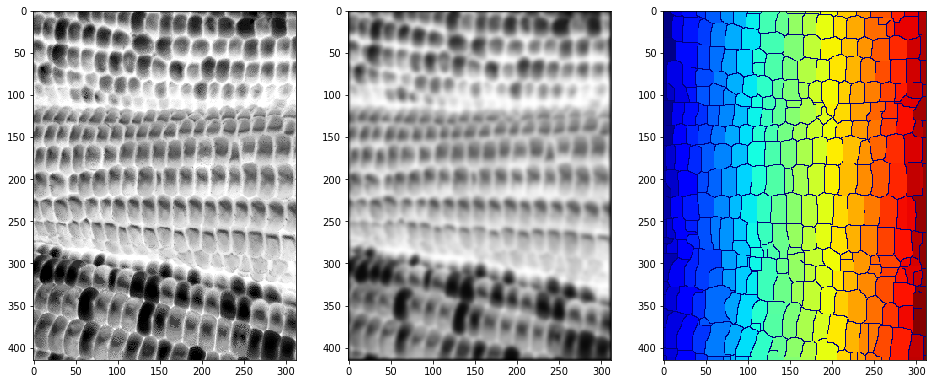

In [3]:
corn = Im.open('corn.tif')
corn_g = corn.convert("L")
corn_gi = 255 - np.array(corn_g)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(corn_gi, cmap='gray')

kernel = np.array(((1, 2, 1), (2, 4, 2), (1, 2, 1))) / 16
d = corn_gi
k = 9
for i in range(k):
    d = sp.signal.convolve2d(d, kernel, 'same')

plt.subplot(132)
plt.imshow(d, cmap='gray')

w = eng.watershed(matlab.double(d.tolist()))
plt.subplot(133)
plt.imshow(w, cmap='jet')

## Question 1
Because in watershed light pixels represnt high elevations

## Question 2
Because it's a high frequency image, a lot of changes in "elevation"

## Question 3
Around 9 times

{'Connectivity': 8.0, 'ImageSize': matlab.double([[415.0,312.0]]), 'NumObjects': 337.0, 'PixelIdxList': [1.0, 21.0, 43.0, 71.0, 93.0, 129.0, 148.0, 178.0, 200.0, 207.0, 229.0, 254.0, 276.0, 285.0, 305.0, 328.0, 345.0, 368.0, 386.0, 408.0, 415.0, 2584.0, 2690.0, 2744.0, 3077.0, 3320.0, 3659.0, 4143.0, 4524.0, 4852.0, 5052.0, 6641.0, 6660.0, 6768.0, 6953.0, 7283.0, 7618.0, 7724.0, 8887.0, 10575.0, 10665.0, 10717.0, 10790.0, 11169.0, 11668.0, 12111.0, 12164.0, 12451.0, 13302.0, 13375.0, 13509.0, 13535.0, 13592.0, 13842.0, 13966.0, 15529.0, 17360.0, 17845.0, 18389.0, 18643.0, 18676.0, 18990.0, 19113.0, 19141.0, 20069.0, 20121.0, 20414.0, 20561.0, 20588.0, 20707.0, 20852.0, 21751.0, 24486.0, 24615.0, 24804.0, 25099.0, 25315.0, 25665.0, 25782.0, 26247.0, 26294.0, 26396.0, 26532.0, 27415.0, 27887.0, 28391.0, 28863.0, 29596.0, 31125.0, 31126.0, 31644.0, 31795.0, 32153.0, 32275.0, 32669.0, 32843.0, 33134.0, 33350.0, 33592.0, 34475.0, 35361.0, 35690.0, 36106.0, 36333.0, 37066.0, 37106.0, 37628.0

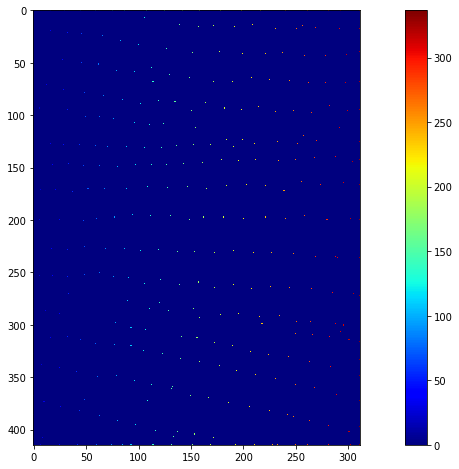

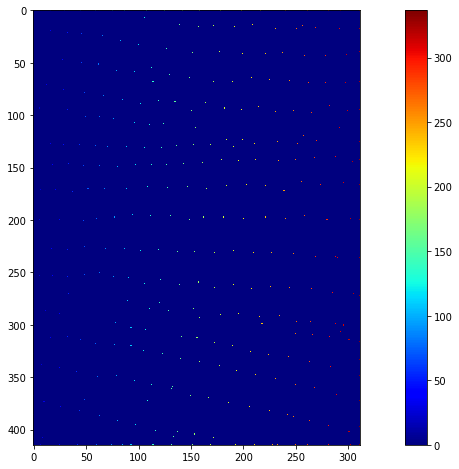

In [4]:
d_min = eng.imregionalmin(matlab.double(d.tolist()))
cc = eng.bwconncomp(d_min, float(8))
im_label = eng.labelmatrix(cc)
plt.figure(figsize=(16,8))
plt.imshow(im_label, cmap='jet')
plt.colorbar()

plt.figure(figsize=(16,8))
plt.imshow(im_label, cmap='jet')
plt.colorbar()

print(cc)

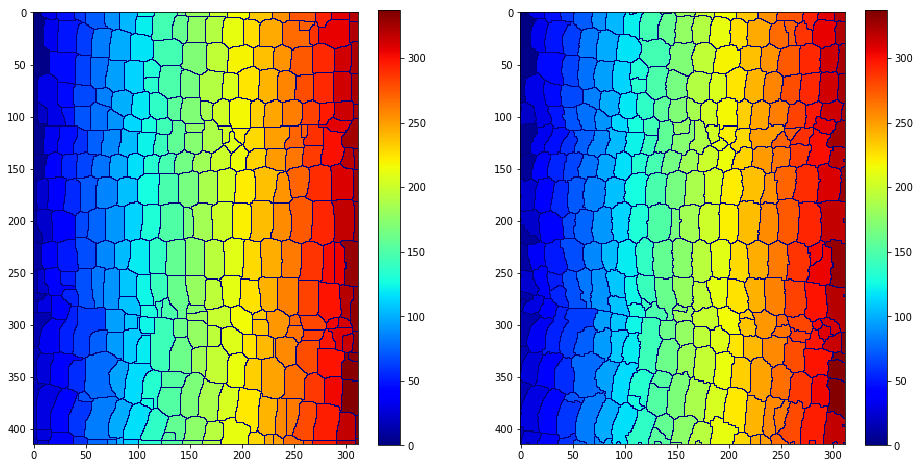

In [5]:
w1 = eng.watershed_meyer(matlab.double(d.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(w1, cmap='jet')
plt.colorbar()

w2 = eng.watershed_meyer(matlab.double(corn_gi.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc)
plt.subplot(122)
plt.imshow(w2, cmap='jet')
plt.colorbar()

## Question 4
The im2gray is more jagged, this might be closer to an actual segmentation.

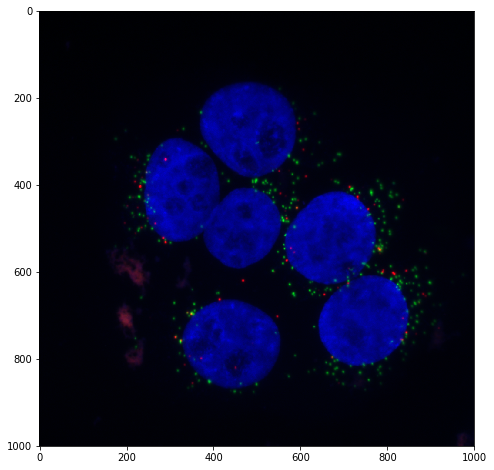

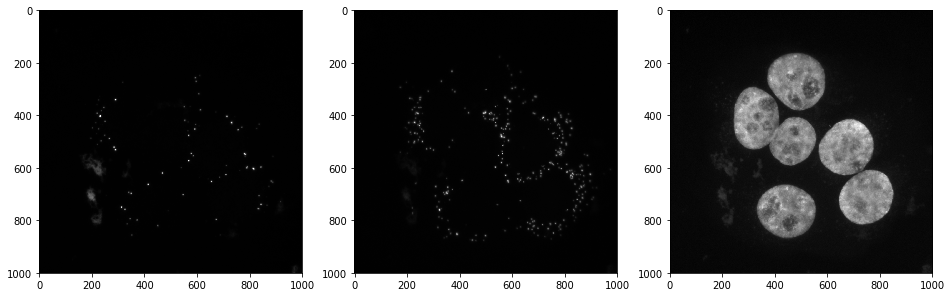

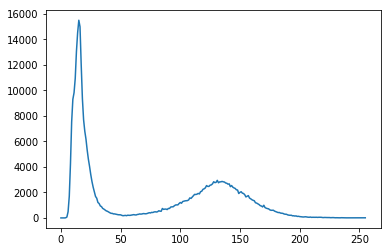

In [18]:
im1 = np.array(Im.open('lab5files/C9minpeps2.bmp'))
plt.figure(figsize=(8,8))
plt.imshow(im1)

im1r = im1[:, :, 0]
im1g = im1[:, :, 1]
im1b = im1[:, :, 2]

im1b_small = im1[200:800, 200:800, 2]
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(im1r, cmap = 'gray')

plt.subplot(132)
plt.imshow(im1g, cmap = 'gray')

plt.subplot(133)
plt.imshow(im1b, cmap = 'gray')

plt.figure()
histo = eng.hist(matlab.double(im1b_small.flatten().tolist()), matlab.double(list(range(256))))
plt.plot(range(256), histo[0]);




In [29]:
def my_0(p, t):
    res = 0
    for x in range(t):
        res += p[x] * x
    return res / sum(p[:t])

def my_1(p, t):
    res = 0
    for x in range(t-1, len(p)):
        res += p[x] * x
    return res / sum(p[t:])

total = sum(histo[0])
p = np.array(histo[0]) / total

def total_prob(p, t):
    return sum(p[0:int(round(t))] / sum(p))

def sigma_squared_0(p, t, my0):
    res = 0
    
    for x in range(t):
        res += p[x] * (x-my0)**2
    #print(res)
    return res / sum(p[:t])
    #return np.std(p[:t])

def sigma_squared_1(p, t, my1):
    res = 0
    for x in range(t, len(p)):
        res += p[x] * (x-my1)**2
    return res / sum(p[t:])

def gaussian(sigma, my, t):
    return (1/ (math.sqrt(sigma * 2 * math.pi))) * \
                math.exp(-1/2.0 * ((t - my)**2/sigma))

def least_error(histo, start_t):
    p = np.array(histo) / np.sum(histo)
    num = len(p)
    t = math.floor(start_t)
    last_t = t+1
    last_last_t = t+2
    
    while abs(last_t - t) > 0.5 and last_last_t != t:
        #t0 = t1
        
        P0 = total_prob(p, t)
        P1 = 1-P0
        
        m0 = my_0(p, t)
        m1 = my_1(p, t)
        
        sigma_0 = sigma_squared_0(p, t, m0)
        sigma_1 = sigma_squared_1(p, t, m1)
        
        #print(P0, P1, m0, m1, sigma_0, sigma_1)
        p0 = gaussian(sigma_0, m0, t)
        p1 = gaussian(sigma_1, m1, t)
        #print('{}, {}, {}, {}, {}, {}, {}, {}'.format(P0, P1, m0, m1, sigma_0, sigma_1, p0, p1))
        
        
        a = 1/((sigma_1 - sigma_0)/(sigma_0*sigma_1))
        b = 2*(-m0/sigma_0 + m1/sigma_1)
        c = -2*np.log(P0/P1) + np.log(sigma_0/sigma_1) + (m0**2)/sigma_0 - (m1**2)/sigma_1
        
        #print(a, b, c)
        r1 = -(a*b)/2 + np.sqrt((a*b/2)**2 - a*c)
        r2 = -(a*b)/2 - np.sqrt((a*b/2)**2 - a*c)
        
        last_last_t = last_t
        last_t = t
        if abs(r1 - t) < abs(r2 - t):
            t = r1
        else:
            t = r2
        
        #print('roots: {}, {}'.format(r1, r2))
        t = int(math.floor(t)) 
        
        
    return t

SE8 = np.array(((1,1,1), (1,1,1), (1,1,1)))
SE4 = np.array(((0,1,0), (1,1,1), (0,1,0)))
def dilate_oct(im, iterations):
    im_doct = scipy.ndimage.binary_dilation(im, SE4, iterations=iterations)
    im_doct = scipy.ndimage.binary_dilation(im_doct, SE8, iterations=iterations)
    return im_doct

def erode_oct(im, iterations):
    im_doct = scipy.ndimage.binary_erosion(im, SE4, iterations=iterations)
    im_doct = scipy.ndimage.binary_erosion(im_doct, SE8, iterations=iterations)
    return im_doct

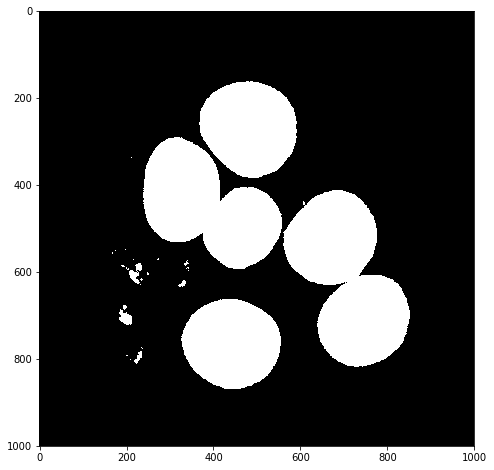

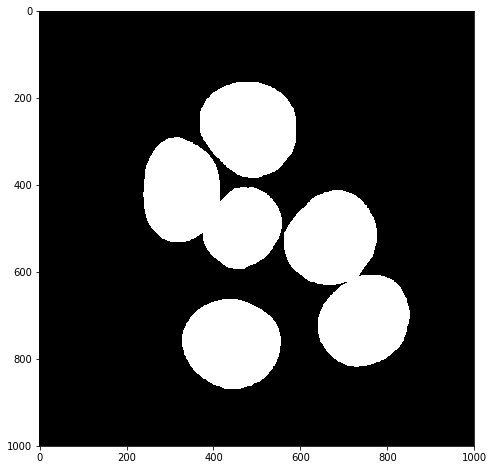

In [34]:
t = least_error(histo[0], 42)

im1bT = im1b > t
plt.figure(figsize=(8,8))
plt.imshow(im1bT, cmap='gray')

tmp = erode_oct(im1bT, 5)
im1bTmorph= dilate_oct(tmp, 5)

plt.figure(figsize=(8,8))
plt.imshow(im1bTmorph, cmap='gray')



In [43]:
d = eng.bwdist(matlab.double((im1bTmorph*-1).tolist()))

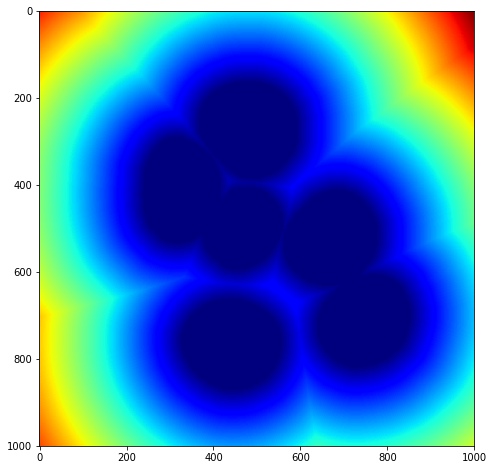

In [42]:
plt.figure(figsize=(8,8))
plt.imshow(d, cmap = "jet")

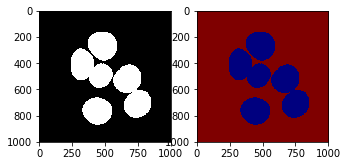

In [73]:
d_inv = np.array(d) * -1
d_inv[~im1bTmorph] = np.min(d_inv)

plt.figure(figsize=(8,8))
plt.subplot(131)
plt.imshow(d_inv, cmap="gray")


d_min = eng.imregionalmin(matlab.double(d_inv.tolist()))
cc = eng.bwconncomp(d_min, float(8))
im_label = eng.labelmatrix(cc)

plt.subplot(132)
plt.imshow(im_label, cmap="jet")

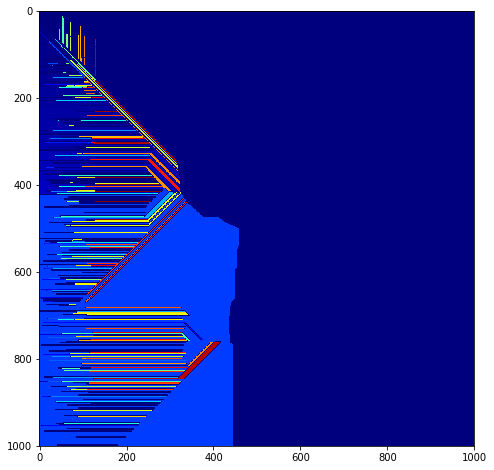

In [70]:
wc = eng.watershed_meyer(matlab.double(d_inv.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc)

plt.figure(figsize=(8,8))
plt.imshow(wc, cmap = "jet")